# Figure 1, Supplemental Figure 1, Supplemental Figure 2

In [400]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uncertainties as u
import math 
from scipy.optimize import minimize, Bounds, differential_evolution
from tqdm.auto import tqdm
import pulp as p
import scipy as scipy
from scipy import stats
import uncertainties as u
import requests
import io
import pandas as pd
import pyppeteer

## Fig. 1 C-H
### Model predicts theoretical conditions for onset of the Warburg Effect

In [401]:
def warburgModel(Glucose_Uptake_Rate, Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP):
    
    '''The Warburg Model primary function is this publication. The function utilizes linear programming to 
    maximize the ATP production rate (mmol ATP per g cellular protein per hour) in the objective function 
    by assigning the functional fraction of fermentation and respiration in the ATP-producing proteome.
    
    The inputs into the model are:
    (1) glucose glucose uptake rate (mmol glucose per g cellular protein per hour)- Glucose_Uptake_Rate
    (2) ATP Yield per molecule of glucose for fermentation and respiation - Y_Glyc & Y_Resp
    (3) Specific activity of fermentation and respiation (mmol per g pathway protein per hr) - V_Resp & V_Glyc
    (4) Fraction of the proteome for ATP-producing enzymes - Mass_Fract_ATP
    
    The outputs of the function are:
    (1) Functional proteome occupancy of fermentation and respiration -  Mass_Fract_Glyc & Mass_Fract_Resp
    (2) Maximal ATP production rate - ATP production rate (mmol per g cellular protein per hour)
    (3) Rate of fermentation and respiration that produce the maximal ATP production rate - Lact_rate & Resp_rate (mmol per g cellular protein per hour)'''

    # Create a LP Maximization problem
    warburg_prob = p.LpProblem('Problem', p.LpMaximize) 
  
    # Create problem Variables 
    Mass_Fract_Glyc = p.LpVariable("Mass_Fract_Glyc", lowBound = 0, upBound = 1, cat='Continuous') 
    Mass_Fract_Resp = p.LpVariable("Mass_Fract_Resp", lowBound = 0, upBound = 1, cat='Continuous')   
  
    # Objective Function
    warburg_prob += Y_Glyc * V_Glyc * Mass_Fract_Glyc + Y_Resp * V_Resp * Mass_Fract_Resp  
  
    # Constraints:
    warburg_prob += V_Glyc * Mass_Fract_Glyc + V_Resp * Mass_Fract_Resp <= Glucose_Uptake_Rate
    warburg_prob += Mass_Fract_Glyc + Mass_Fract_Resp <= Mass_Fract_ATP
  
    status = warburg_prob.solve()   # Solver
     
    Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
    Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp + p.value(Mass_Fract_Glyc) * V_Glyc
    CO2_rate =  6 * p.value(Mass_Fract_Resp) * V_Resp
  
    # Printing the final solution
    return(p.value(Mass_Fract_Glyc), p.value(Mass_Fract_Resp), p.value(warburg_prob.objective), Lact_rate, Resp_rate, CO2_rate) 



In [402]:
def warburgLoop(GUR, V_Glyc_Loop, V_Resp_Loop, Y_Glyc_Loop, Y_Resp_Loop):
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output. 
    Note that for Figure 1, the data is only sampled once since only one value if used for each parameter in the 
    theoretical section.'''

    results_final = []
    for j in tqdm(range(1)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        Mass_Fract_ATP = 0.2
        V_Glyc = V_Glyc_Loop
        V_Resp = V_Resp_Loop
        Y_Glyc = Y_Glyc_Loop
        Y_Resp = Y_Resp_Loop
         
    
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
        co2 = []
    
        gluc = GUR
    
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP))
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            co2.append(loop_result[5])
        results = [glyc_mass, resp_mass, atp, lact, o2, co2]

        results_final.append(results)
    
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
            df_temp_gluc = pd.DataFrame({'gluc' : gluc})
            df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
            df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
            df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
            df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
            df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
            out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
            df = pd.concat([df, out])
            
    return(df)

In [403]:
#Y_resp > Y_glyc & Y_resp * V_resp > Y_glyc * V_glyc
glucose_test = np.linspace(.001 / 60 , 11 / 60 ,500)
VG = 0.01 / 60 
VR = 3 / 60 
YG = 2
YR = 15
mix_1 = warburgLoop(glucose_test, VG, VR, YG, YR)
mix_1['Fraction_Boundary'] = 0
mix_1.loc[mix_1['glyc_mass'] >= 0.2, 'Fraction_Boundary'] = 2
mix_1.loc[(mix_1['glyc_mass'] < 0.2) & (mix_1['glyc_mass'] > 0), 'Fraction_Boundary'] = 1
mix_1['ATP_ferm'] = mix_1['glyc_mass'] * VG * YG
mix_1['ATP_resp'] = mix_1['resp_mass'] * VR * YR
mix_1['ATP_total'] = mix_1['ATP_ferm'] + mix_1['ATP_resp']

#Y_resp < Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
glucose_test = np.linspace(.001 / 60 ,11 / 60 ,500)
VG = 50 / 60 
VR = 3 / 60 
YG = 2
YR = 1
mix_2 = warburgLoop(glucose_test, VG, VR, YG, YR)
mix_2['Fraction_Boundary'] = 0
mix_2.loc[mix_2['glyc_mass'] >= 0.2, 'Fraction_Boundary'] = 2
mix_2.loc[(mix_2['glyc_mass'] < 0.2) & (mix_2['glyc_mass'] > 0), 'Fraction_Boundary'] = 1
mix_2['ATP_ferm'] = mix_2['glyc_mass'] * VG * YG
mix_2['ATP_resp'] = mix_2['resp_mass'] * VR * YR
mix_2['ATP_total'] = mix_2['ATP_ferm'] + mix_2['ATP_resp']

#Y_resp > Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
#glucose_test = np.linspace(.001 / 60 ,11 / 60 ,500)
glucose_test = np.linspace(.001 / 60 ,11 / 60 ,500)
VG = 50 / 60 
VR = 3 / 60 
YG = 2
YR = 15
mix_3 = warburgLoop(glucose_test, VG, VR, YG, YR)
mix_3['Fraction_Boundary'] = 0
mix_3.loc[mix_3['glyc_mass'] >= 0.2, 'Fraction_Boundary'] = 2
mix_3.loc[(mix_3['glyc_mass'] < 0.2) & (mix_3['glyc_mass'] > 0), 'Fraction_Boundary'] = 1
mix_3['ATP_ferm'] = mix_3['glyc_mass'] * VG * YG
mix_3['ATP_resp'] = mix_3['resp_mass'] * VR * YR
mix_3['ATP_total'] = mix_3['ATP_ferm'] + mix_3['ATP_resp']

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

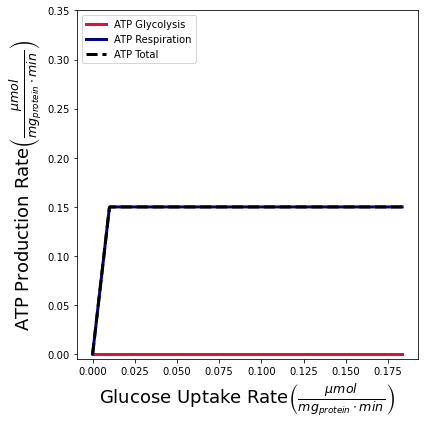

In [404]:
#Fig. 1c
#Y_resp > Y_glyc & Y_resp * V_resp > Y_glyc * V_glyc
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')

color_dict = dict({0:'pink',
                   1:'purple',
                   2: 'crimson'})

sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_1, color = 'crimson', linewidth = 3)
fig.set_size_inches(6,6)
plt.tight_layout()

sns.lineplot(x="gluc", y="ATP_resp",        
              data=mix_1, color = 'darkblue', linewidth = 3)
fig.set_size_inches(6,6)

sns.lineplot(x="gluc", y="ATP_total",        
              data=mix_1, color = 'black', linewidth = 3, linestyle='--')
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["ATP Glycolysis", "ATP Respiration", 'ATP Total'])
fig.set_size_inches(6,6)

ax.set_ylim(-0.3/ 60 ,21/ 60)
plt.tight_layout()

fig.savefig('./Figures/fig1c.svg',format='svg', dpi=1200)

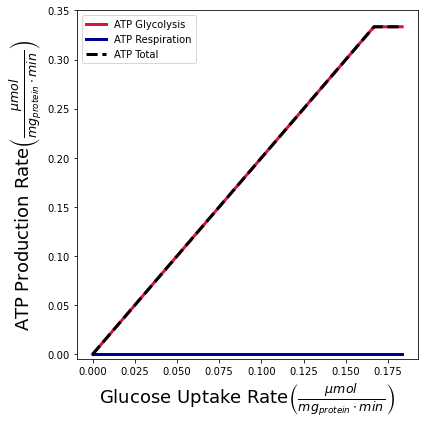

In [405]:
#Fig. 1d
#Y_resp < Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')

color_dict = dict({0:'darkblue',
                   1:'purple',
                   2: 'crimson'})

sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_2, color = 'crimson', linewidth = 3)
fig.set_size_inches(6,6)
plt.tight_layout()

sns.lineplot(x="gluc", y="ATP_resp",        
              data=mix_2, color = 'darkblue', linewidth = 3)
fig.set_size_inches(6,6)

sns.lineplot(x="gluc", y="ATP_total",        
              data=mix_2, color = 'black', linewidth = 3, linestyle='--')
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["ATP Glycolysis", "ATP Respiration", 'ATP Total'])
fig.set_size_inches(6,6)

ax.set_ylim(-0.3 / 60 ,21 / 60)

plt.tight_layout()

fig.savefig('./Figures/fig1d.svg',format='svg', dpi=1200)

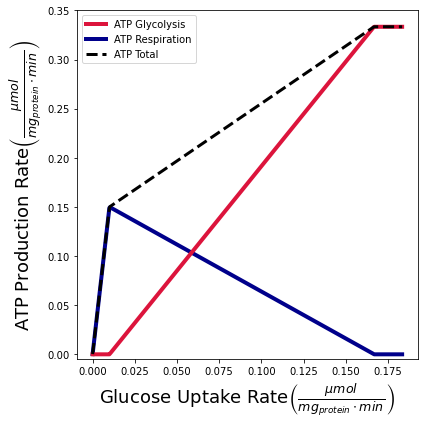

In [406]:
#Fig. 1e
#Y_resp > Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')

color_dict = dict({0:'darkblue',
                   1:'purple',
                   2: 'crimson'})

sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_3, color = 'crimson', linewidth = 4, zorder = 2)
fig.set_size_inches(8,6)
plt.tight_layout()

sns.lineplot(x="gluc", y="ATP_resp",        
              data=mix_3, color = 'darkblue', linewidth = 4, zorder = 1)
fig.set_size_inches(6,6)

sns.lineplot(x="gluc", y="ATP_total",        
              data=mix_3, color = 'black', linewidth = 3, linestyle='--', zorder = 3)

ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["ATP Glycolysis", "ATP Respiration", 'ATP Total'])
fig.set_size_inches(6,6)

ax.set_ylim(-0.3/ 60, 21 / 60)

#ax.set_xlim(-0.03/ 60, 0.01)
#ax.set_ylim(-0.3/ 60, .2)

plt.tight_layout()

#save fig
fig.savefig('./Figures/fig1e.svg',format='svg', dpi=1200)

In [408]:
def warburgLoop(GUR, V_Glyc_Loop, V_Resp_Loop, Y_Glyc_Loop, Y_Resp_Loop, Prot_Allocation):
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output. 
    Note that for Figure 1, the data is only sampled once since only one value if used for each parameter in the 
    theoretical section.'''

    results_final = []
    for j in tqdm(range(1)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        Mass_Fract_ATP = Prot_Allocation
        V_Glyc = V_Glyc_Loop
        V_Resp = V_Resp_Loop
        Y_Glyc = Y_Glyc_Loop
        Y_Resp = Y_Resp_Loop
         
    
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
        co2 = []
    
        gluc = GUR
    
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP))
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            co2.append(loop_result[5])
        results = [glyc_mass, resp_mass, atp, lact, o2, co2]

        results_final.append(results)
    
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
            df_temp_gluc = pd.DataFrame({'gluc' : gluc})
            df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
            df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
            df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
            df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
            df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
            out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
            df = pd.concat([df, out])
            
    return(df)

In [409]:
#Y_resp < Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
glucose_test = np.linspace(.001 / 60 ,35 / 60 ,1000)
VG = 50 / 60 
VR = 3 / 60 
YG = 2
YR = 15
PA = 0.2
mix_2 = warburgLoop(glucose_test, VG, VR, YG, YR, PA)
mix_2['Fraction_Boundary'] = 0
mix_2.loc[mix_2['glyc_mass'] >= 0.2, 'Fraction_Boundary'] = 2
mix_2.loc[(mix_2['glyc_mass'] < 0.2) & (mix_2['glyc_mass'] > 0), 'Fraction_Boundary'] = 1
mix_2['ATP_ferm'] = mix_2['glyc_mass'] * VG * YG
mix_2['ATP_resp'] = mix_2['resp_mass'] * VR * YR
mix_2['ATP_total'] = mix_2['ATP_ferm'] + mix_2['ATP_resp']


#Y_resp > Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
glucose_test = np.linspace(.001 / 60 ,35 / 60 ,1000)
VG = 50 / 60 
VR = 3 / 60 
YG = 2
YR = 15
PA = 0.4
mix_3 = warburgLoop(glucose_test, VG, VR, YG, YR, PA)
mix_3['Fraction_Boundary'] = 0
mix_3.loc[mix_3['glyc_mass'] >= 0.5, 'Fraction_Boundary'] = 2
mix_3.loc[(mix_3['glyc_mass'] < 0.5) & (mix_3['glyc_mass'] > 0), 'Fraction_Boundary'] = 1
mix_3['ATP_ferm'] = mix_3['glyc_mass'] * VG * YG
mix_3['ATP_resp'] = mix_3['resp_mass'] * VR * YR
mix_3['ATP_total'] = mix_3['ATP_ferm'] + mix_3['ATP_resp']

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

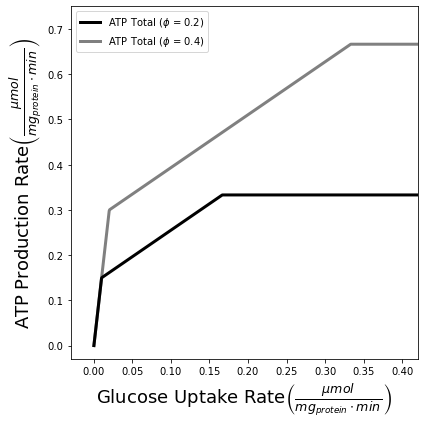

In [399]:
#Fig. 1F
#ATP Production for phi = 0.2 and phi = 0.4
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')
fig.set_size_inches(8,6)
plt.tight_layout()
fig.set_size_inches(6,6)

color_dict = dict({0:'darkblue',
                   1:'purple',
                   2: 'crimson'})


sns.lineplot(x="gluc", y="ATP_total",        
             data=mix_2, color = 'black', linewidth = 3, zorder = 2)

sns.lineplot(x="gluc", y="ATP_total",        
              data=mix_3, color = 'grey', linewidth = 3, zorder = 1)


ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["ATP Total ($ \phi$ = 0.2)", "ATP Total ($ \phi$ = 0.4)"])
fig.set_size_inches(6,6)

ax.set_xlim(-0.03, 0.42)
ax.set_ylim(-0.03, 0.75)

plt.tight_layout()

#save fig
fig.savefig('./Figures/fig1f.svg',format='svg', dpi=1200)

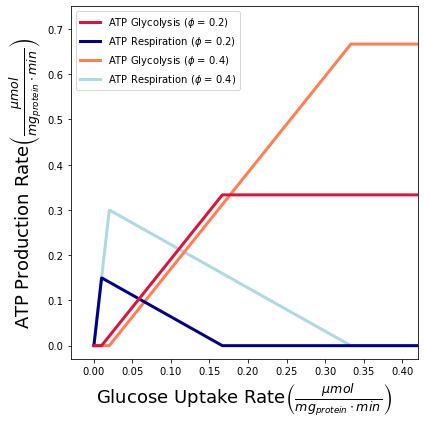

In [410]:
#Fig. 1e
#Y_resp > Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')
fig.set_size_inches(8,6)
plt.tight_layout()
fig.set_size_inches(6,6)

color_dict = dict({0:'darkblue',
                   1:'purple',
                   2: 'crimson'})

sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_2, color = 'crimson', linewidth = 3, zorder = 4)

sns.lineplot(x="gluc", y="ATP_resp",        
              data=mix_2, color = 'darkblue', linewidth = 3, zorder = 3)


sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_3, color = 'coral', linewidth = 3, zorder = 2)


sns.lineplot(x="gluc", y="ATP_resp",        
              data=mix_3, color = 'lightblue', linewidth = 3, zorder = 1)



ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["ATP Glycolysis ($ \phi$ = 0.2)", "ATP Respiration ($ \phi$ = 0.2)", "ATP Glycolysis ($ \phi$ = 0.4)", "ATP Respiration ($ \phi$ = 0.4)"])
fig.set_size_inches(6,6)

ax.set_xlim(-0.03, .42)
ax.set_ylim(-0.03, 0.75)

#ax.set_ylim(-0.3/ 60, 0.14)
#ax.set_xlim(0.0003, .005)

plt.tight_layout()

#save fig
fig.savefig('./Figures/fig1g.svg',format='svg', dpi=1200)

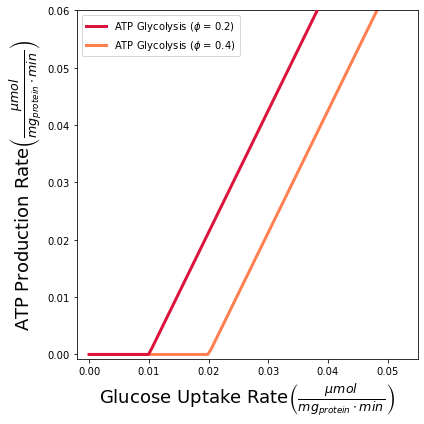

In [411]:
#Fig. 1e
#Y_resp > Y_glyc & Y_resp * V_resp < Y_glyc * V_glyc
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')
fig.set_size_inches(8,6)
plt.tight_layout()
fig.set_size_inches(6,6)

color_dict = dict({0:'darkblue',
                   1:'purple',
                   2: 'crimson'})

sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_2, color = 'crimson', linewidth = 3, zorder = 4)

#sns.lineplot(x="gluc", y="ATP_resp",        
#              data=mix_2, color = 'darkblue', linewidth = 3, zorder = 3)


sns.lineplot(x="gluc", y="ATP_ferm",       
              data=mix_3, color = 'coral', linewidth = 3, zorder = 2)


#sns.lineplot(x="gluc", y="ATP_resp",        
#              data=mix_3, color = 'lightblue', linewidth = 3, zorder = 1)



ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["ATP Glycolysis ($ \phi$ = 0.2)", "ATP Glycolysis ($ \phi$ = 0.4)", "ATP Respiration ($ \phi$ = 0.4)"])
fig.set_size_inches(6,6)

#ax.set_xlim(-0.1, .5)
#ax.set_ylim(-0.03, 1)

ax.set_ylim(-0.05/ 60, 0.06)
ax.set_xlim(-0.002, .055)

plt.tight_layout()

#save fig
fig.savefig('./Figures/fig1h.svg',format='svg', dpi=1200)

## Supplemental Fig. 1 A-H
### Model predictions under varying glucose uptake rates

In [417]:
def warburgLoop(GUR, V_Glyc_Loop, V_Resp_Loop, Y_Glyc_Loop, Y_Resp_Loop):
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output. 
    Note that for Figure 1, the data is only sampled once since only one value if used for each parameter in the 
    theoretical section.'''

    results_final = []
    for j in tqdm(range(1)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        Mass_Fract_ATP = 0.2
        V_Glyc = V_Glyc_Loop
        V_Resp = V_Resp_Loop
        Y_Glyc = Y_Glyc_Loop
        Y_Resp = Y_Resp_Loop
         
    
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
        co2 = []
    
        gluc = GUR
    
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP))
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            co2.append(loop_result[5])
        results = [glyc_mass, resp_mass, atp, lact, o2, co2]

        results_final.append(results)
    
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
            df_temp_gluc = pd.DataFrame({'gluc' : gluc})
            df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
            df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
            df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
            df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
            df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
            out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
            df = pd.concat([df, out])
            
    return(df)

In [418]:
#Varying glucose uptake rates
glucose_test = np.array([.1/ 60,2/ 60,7/ 60,11/ 60])
Y_Glyc = 2 
Y_Resp = 20
VG = 50/ 60
VR = .5/ 60
df = warburgLoop(glucose_test, VG, VR, Y_Glyc, Y_Resp)

  0%|          | 0/1 [00:00<?, ?it/s]

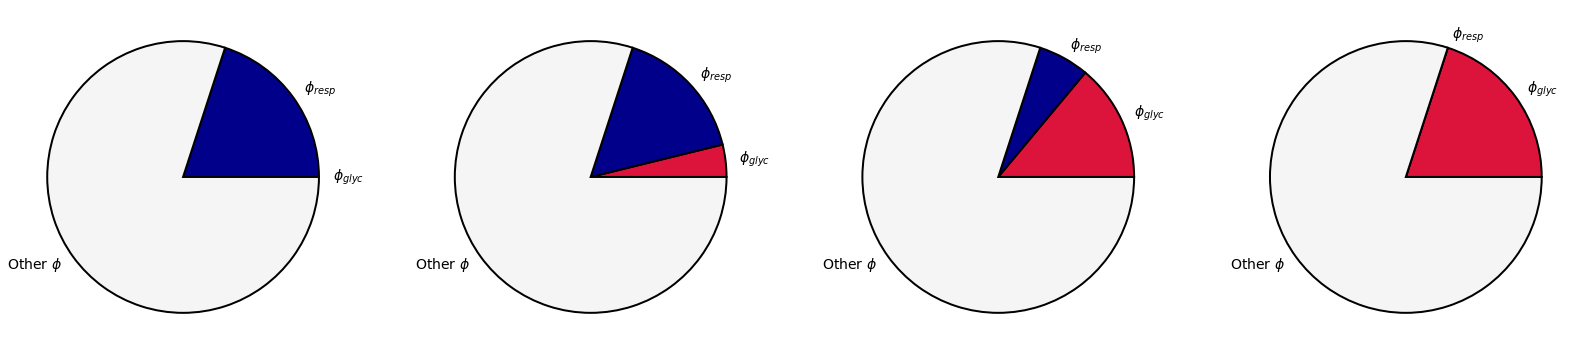

In [419]:
#Extended Data Fig. 1a-d
fig, ax = plt.subplots(1,4, figsize = (28,7))

y = np.array([df['glyc_mass'][0], df['resp_mass'][0], 1-(df['glyc_mass'][0] + df['resp_mass'][0])])
labels = [r"$\phi_{glyc}$", r"$\phi_{resp}$", 'Other' ' '  r"$\phi$"]
colors = ["crimson", "darkblue", "whitesmoke"]
ax[0].pie(y, labels = labels, colors = colors, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True}, textprops={'fontsize': 14})


y = np.array([df['glyc_mass'][1], df['resp_mass'][1], 1-(df['glyc_mass'][1] + df['resp_mass'][1])])
labels = [r"$\phi_{glyc}$", r"$\phi_{resp}$", 'Other' ' '  r"$\phi$"]
colors = ["crimson", "darkblue", "whitesmoke"]
ax[1].pie(y, labels = labels, colors = colors, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True}, textprops={'fontsize': 14})

y = np.array([df['glyc_mass'][2], df['resp_mass'][2], 1-(df['glyc_mass'][2] + df['resp_mass'][2])])
labels = [r"$\phi_{glyc}$", r"$\phi_{resp}$", 'Other' ' '  r"$\phi$"]
colors = ["crimson", "darkblue", "whitesmoke"]
ax[2].pie(y, labels = labels, colors = colors, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True}, textprops={'fontsize': 14})

y = np.array([df['glyc_mass'][3], df['resp_mass'][3], 1-(df['glyc_mass'][3] + df['resp_mass'][3])])
labels = [r"$\phi_{glyc}$", r"$\phi_{resp}$", 'Other' ' '  r"$\phi$"]
colors = ["crimson", "darkblue", "whitesmoke"]
ax[3].pie(y, labels = labels, colors = colors, wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True}, textprops={'fontsize': 14})

#save fig
fig.savefig('./Figures/edf1a_proteome_fraction.svg',format='svg', dpi=1200)

In [420]:
Mass_Fract_ATP = .2
Y_Resp = 30
Y_Glyc = 2
V_Glyc = 50 / 60
V_Resp = 0.5 / 60

Mass_Fract_Glyc = np.linspace(.0001 , 1 ,1000)
ATP_prod = np.zeros(len(Mass_Fract_Glyc)) 

def warburgMax(Glucose_uptake_rate, Mass_Fract_Glyc):
    
    '''Reports the ATP production rate for each glucose uptake rate and fraction of fermentation utilized'''

    for i in range(len(Mass_Fract_Glyc)):  
        Mass_Fract_Resp = Mass_Fract_ATP - Mass_Fract_Glyc[i]
        Ferm_rate = Mass_Fract_Glyc[i] * V_Glyc
        Resp_rate = Mass_Fract_Resp * V_Resp
        Ferm_fract = Ferm_rate / (Ferm_rate + Resp_rate)
        Resp_fract = Resp_rate / (Ferm_rate + Resp_rate)
        V_ATP = Y_Glyc * V_Glyc * Mass_Fract_Glyc[i] + Y_Resp * V_Resp * Mass_Fract_Resp 
        V_Gluc = (Y_Resp * Glucose_uptake_rate * Resp_fract) + (Y_Glyc * Glucose_uptake_rate * Ferm_fract)
        #print(V_Gluc)
        if Glucose_uptake_rate >= (V_Glyc * Mass_Fract_Glyc[i]) + (V_Resp * Mass_Fract_Resp):
            ATP_prod[i] = V_ATP
        elif Glucose_uptake_rate < (V_Glyc * Mass_Fract_Glyc[i]) + (V_Resp * Mass_Fract_Resp): 
            ATP_prod[i] = V_Gluc 
    return(ATP_prod)     
    


0.049976678210952245
0.10430068223381335
0.24745825189942566
0.33333333333333337


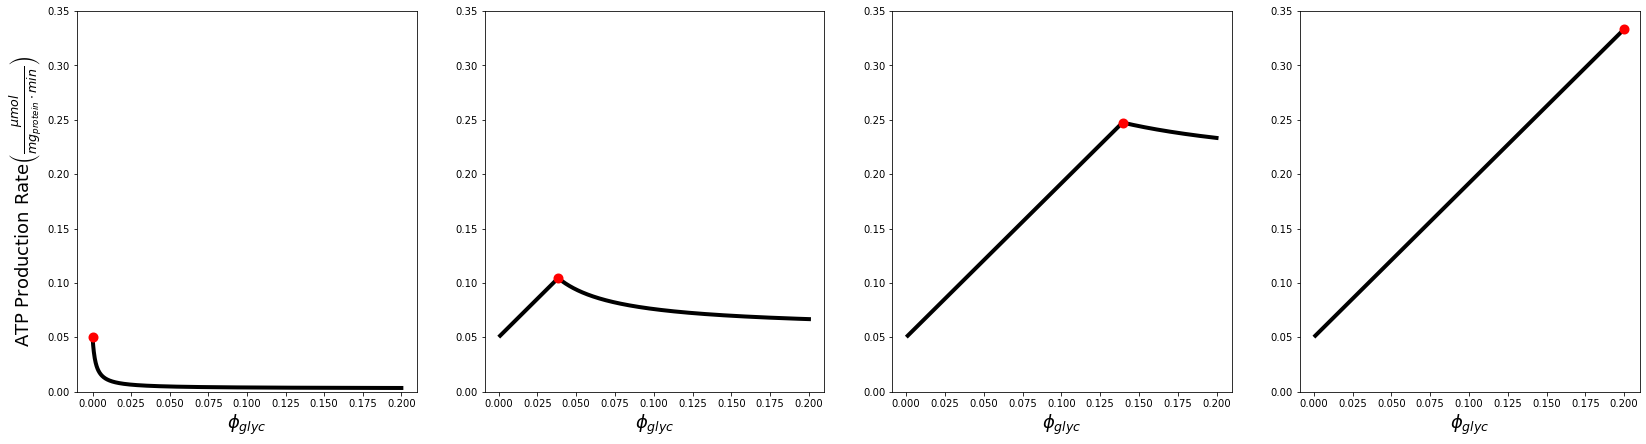

In [421]:
#Extended Data Fig. 1e-h
fig, ax = plt.subplots(1,4, figsize = (28,7))

Glucose_uptake_rate = .1 / 60
Mass_Fract_Glyc = np.linspace(.000001,Mass_Fract_ATP,1000)
ATP_prod = np.zeros(len(Mass_Fract_Glyc)) 
warburgMax(Glucose_uptake_rate, Mass_Fract_Glyc)
ax[0].plot(Mass_Fract_Glyc, ATP_prod, color = 'black', linewidth = 4, zorder=1)
print(max(ATP_prod))
df = pd.DataFrame({'Fraction' : Mass_Fract_Glyc, 'ATP' : ATP_prod})
ax[0].scatter(df.loc[df['ATP'] == max(ATP_prod), 'Fraction'][0], df.loc[df['ATP'] == max(ATP_prod), 'ATP'][0], color = 'red', linewidth = 4, zorder=2)
ax[0].set_ylim([0, 21/ 60])
#ax[0].set_xlim([0, .35])
ax[0].set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax[0].set_xlabel(r"$\phi_{glyc}$", fontsize=18)

Glucose_uptake_rate = 2/ 60
Mass_Fract_Glyc = np.linspace(.001,Mass_Fract_ATP,1000)
ATP_prod = np.zeros(len(Mass_Fract_Glyc)) 
warburgMax(Glucose_uptake_rate, Mass_Fract_Glyc)
print(max(ATP_prod))
ax[1].plot(Mass_Fract_Glyc, ATP_prod, color = 'black', linewidth = 4, zorder=1)
df = pd.DataFrame({'Fraction' : Mass_Fract_Glyc, 'ATP' : ATP_prod})
ax[1].scatter(df.loc[df['ATP'] == max(ATP_prod), 'Fraction'], df.loc[df['ATP'] == max(ATP_prod), 'ATP'], color = 'red', linewidth = 4, zorder=2)
ax[1].set_ylim([0, 21/ 60])
ax[1].set_xlabel(r"$\phi_{glyc}$", fontsize=18)

Glucose_uptake_rate = 7/ 60
Mass_Fract_Glyc = np.linspace(.001,Mass_Fract_ATP,1000)
ATP_prod = np.zeros(len(Mass_Fract_Glyc)) 
warburgMax(Glucose_uptake_rate, Mass_Fract_Glyc)
print(max(ATP_prod))
ax[2].plot(Mass_Fract_Glyc, ATP_prod, color = 'black', linewidth = 4, zorder=1)
df = pd.DataFrame({'Fraction' : Mass_Fract_Glyc, 'ATP' : ATP_prod})
ax[2].scatter(df.loc[df['ATP'] == max(ATP_prod), 'Fraction'], df.loc[df['ATP'] == max(ATP_prod), 'ATP'], color = 'red', linewidth = 4, zorder=2)
ax[2].set_ylim([0, 21/ 60])
ax[2].set_xlabel(r"$\phi_{glyc}$", fontsize=18)

Glucose_uptake_rate = 11/ 60
Mass_Fract_Glyc = np.linspace(.001,Mass_Fract_ATP,1000)
ATP_prod = np.zeros(len(Mass_Fract_Glyc)) 
warburgMax(Glucose_uptake_rate, Mass_Fract_Glyc)
print(max(ATP_prod))
ax[3].plot(Mass_Fract_Glyc, ATP_prod, color = 'black', linewidth = 4, zorder=1)
df = pd.DataFrame({'Fraction' : Mass_Fract_Glyc, 'ATP' : ATP_prod})
ax[3].scatter(df.loc[df['ATP'] == max(ATP_prod), 'Fraction'], df.loc[df['ATP'] == max(ATP_prod), 'ATP'], color = 'red', linewidth = 4, zorder=2)
ax[3].set_ylim([0, 21/ 60])
ax[3].set_xlabel(r"$\phi_{glyc}$", fontsize=18)

fig.savefig('./Figures/edf1b_maximal_atp_production.svg',format='svg', dpi=1200)

## Supplemental Fig. 2 A-B
### Model predictions under varying glucose and respiratory substrate uptake rates

In [422]:
def warburgModel(Glucose_Uptake_Rate, RespSub_Uptake_Rate, Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP):
    
    '''The Warburg Model primary function is this publication. The function utilizes linear programming to 
    maximize the ATP production rate (mmol ATP per g cellular protein per hour) in the objective function 
    by assigning the functional fraction of fermentation and respiration in the ATP-producing proteome. 
    This version differs in that it also accomodates an input for a repiratory substrate uprake rate.  
    
    The inputs into the model are:
    (1) glucose uptake rate (mmol glucose per g cellular protein per hour) - Glucose_Uptake_Rate
    (2) repiratory substrate uprake rate (mmol substrate per g cellular protein per hour) - RespSub_Uptake_Rate
    (3) ATP Yield per molecule of glucose for fermentation and respiation - Y_Glyc & Y_Resp
    (4) Specific activity of fermentation and respiation (mmol per g pathway protein per hr) - V_Resp & V_Glyc
    (5) Fraction of the proteome for ATP-producing enzymes - Mass_Fract_ATP
    
    The outputs of the function are:
    (1) Functional proteome occupancy of fermentation and respiration -  Mass_Fract_Glyc & Mass_Fract_Resp
    (2) Maximal ATP production rate - ATP production rate (mmol per g cellular protein per hour)
    (3) Rate of fermentation and respiration that produce the maximal ATP production rate - Lact_rate & Resp_rate (mmol per g cellular protein per hour)'''

    # Create a LP Maximization problem
    warburg_prob = p.LpProblem('Problem', p.LpMaximize) 
  
    # Create problem Variables 
    Mass_Fract_Glyc = p.LpVariable("Mass_Fract_Glyc", lowBound = 0, upBound = 1, cat='Continuous') 
    Mass_Fract_Resp = p.LpVariable("Mass_Fract_Resp", lowBound = 0, upBound = 1, cat='Continuous') 
    Mass_Fract_Resp_Glu = p.LpVariable("Mass_Fract_Resp_Glu", lowBound = 0, upBound = 1, cat='Continuous')
    Mass_Fract_Resp_Rsub = p.LpVariable("Mass_Fract_Resp_Rsub", lowBound = 0, upBound = 1, cat='Continuous')
  
    # Objective Function
    warburg_prob += Y_Glyc * V_Glyc * Mass_Fract_Glyc + Y_Resp * V_Resp * Mass_Fract_Resp 
  
    # Constraints:
    warburg_prob += V_Glyc * Mass_Fract_Glyc + V_Resp * Mass_Fract_Resp_Glu <= Glucose_Uptake_Rate
    warburg_prob += Mass_Fract_Glyc + Mass_Fract_Resp <= Mass_Fract_ATP
    warburg_prob += Mass_Fract_Resp_Glu + Mass_Fract_Resp_Rsub == Mass_Fract_Resp
    warburg_prob += V_Resp * Mass_Fract_Resp_Rsub <= RespSub_Uptake_Rate
  
    status = warburg_prob.solve()   # Solver
     
    Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
    Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp 
  
    # Printing the final solution
    return(p.value(Mass_Fract_Glyc), p.value(Mass_Fract_Resp), p.value(warburg_prob.objective), Lact_rate, Resp_rate)



In [429]:
#def V_Resp, V_Glyc, gluc
def warburgLoop(GUR, RUR, V_Glyc_Loop, V_Resp_Loop, Y_Glyc_Loop, Y_Resp_Loop):

    results_final = []
    for j in tqdm(range(1)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        Mass_Fract_ATP = 0.2
        V_Glyc = V_Glyc_Loop
        V_Resp = V_Resp_Loop
        Y_Glyc = Y_Glyc_Loop
        Y_Resp = Y_Resp_Loop
         
    
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
        co2 = []
    
        gluc = GUR
    
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], RUR, Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP))
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
        results = [glyc_mass, resp_mass, atp, lact, o2]

        results_final.append(results)
    
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
            df_temp_gluc = pd.DataFrame({'gluc' : gluc})
            df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
            df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
            df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
            df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
            df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
            out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
            df = pd.concat([df, out])
            
    return(df)

In [430]:
#Defining glucose and respiratory substrate uptake rates
glucose_uptake = np.linspace(.001 / 60,12 / 60,1000)
#no respiratory substrate uptake 
resp_sub_uptake = 0 / 60

#Assigning values for fermentation specific activity (VG), respiration specific activity (VR), 
#fermentation yield (YG), and respiration yield (YR)
VG = 50 / 60 
VR = 3 / 60 
YG = 2
YR = 15

#Results of the above functions
result = warburgLoop(glucose_uptake, resp_sub_uptake, VG, VR, YG, YR)

#Calculating the ATP production rate from fermentation and respiration 
result['ATP_ferm'] = result['glyc_mass'] * VG * YG
result['ATP_resp'] = result['resp_mass'] * VR * YR

  0%|          | 0/1 [00:00<?, ?it/s]

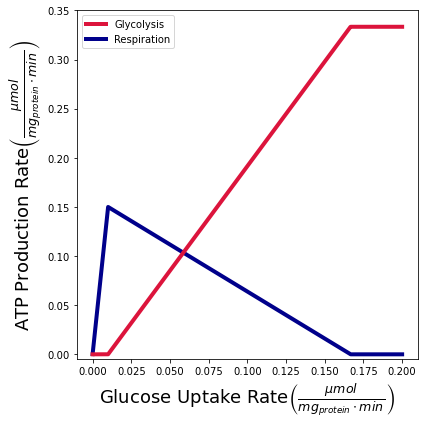

In [431]:
#plotting the results
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')

#ATP production rate from fermentation
sns.lineplot(x="gluc", y="ATP_ferm",       
              data=result, color = 'crimson', linewidth = 4, zorder = 2)
fig.set_size_inches(8,6)
plt.tight_layout()

#ATP production rate from respiration
sns.lineplot(x="gluc", y="ATP_resp",        
              data=result, color = 'darkblue', linewidth = 4, zorder = 1)
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["Glycolysis", "Respiration"])
fig.set_size_inches(6,6)

ax.set_ylim(-0.3/ 60,21/ 60)

plt.tight_layout()

#save figure
fig.savefig('./Figures/edf2a_no_respiratory_substrate_uptake.svg',format='svg', dpi=1200)

In [434]:
#Defining glucose and respiratory substrate uptake rates
glucose_uptake = np.linspace(.0001 / 60, 12 / 60,1000)
#Saturating respiratory substrate uptake 
resp_sub_uptake = 3.1 / 60

#Assigning values for fermentation specific activity (VG), respiration specific activity (VR), 
#fermentation yield (YG), and respiration yield (YR)
VG = 50 / 60 
VR = 3 / 60 
YG = 2
YR = 15

#Results of the above functions
result = warburgLoop(glucose_uptake, resp_sub_uptake, VG, VR, YG, YR)

#Calculating the ATP production rate from fermentation and respiration 
result['ATP_ferm'] = result['glyc_mass'] * VG * YG
result['ATP_resp'] = result['resp_mass'] * VR * YR

  0%|          | 0/1 [00:00<?, ?it/s]

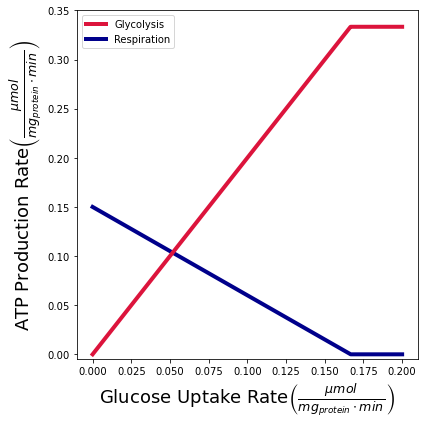

In [435]:
#plotting the results
fig, ax = plt.subplots(figsize=(8,2))
ax.patch.set_facecolor('white')

#ATP production rate from fermentation
sns.lineplot(x="gluc", y="ATP_ferm",       
              data=result, color = 'crimson', linewidth = 4, zorder = 2)
fig.set_size_inches(8,6)
plt.tight_layout()

#ATP production rate from respiration
sns.lineplot(x="gluc", y="ATP_resp",        
              data=result, color = 'darkblue', linewidth = 4, zorder = 1)
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
ax.set_ylabel("ATP Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=18)
plt.legend(title=False, loc='upper left', labels=["Glycolysis", "Respiration"])
fig.set_size_inches(6,6)

ax.set_ylim(-0.3/ 60,21/ 60)

plt.tight_layout()

#save figure
fig.savefig('./Figures/edf2b_saturating_respiratory_substrate_uptake.svg',format='svg', dpi=1200)